# Numpyro MCMC

In [1]:
import sys
# add ../ to the path
sys.path.append('../')

In [2]:
# generic & ml
import config as cfg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
from collections import namedtuple
from sklearn.decomposition import PCA
import scanpy as sc

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import seed, trace
import pprint as pp

import module as md

jax_models successfully imported.


In [3]:
default_device = jax.devices()[0]
print(default_device)

TFRT_CPU_0


# Loading data

In [4]:
path = "../" + cfg.path
path

'../data/130723_data_hepatocytes.h5ad'

In [5]:
data_0, data, n_c, dm, sample_id, sample_names = md.get_data_from_anndata(
    path, cfg.genes
)
# some useful variables
NC, NG = data.shape
NS = dm.shape[1]

/Users/salati/Documents/CODE/github/LiverZonation/other_methods/../module/utils.py:59: ImplicitModificationWarning: Setting element `.layers['n_cg']` of view, initializing view as actual.
  data.layers["n_cg"] = data.X.toarray()


### PCA to initalize the lobular coordinate $x$

In [6]:
pca = PCA(n_components=2, whiten=False)
X_pca = data.layers["f_cg"]

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]
PC = pca.fit_transform(X_pca)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'PC2 entries values')

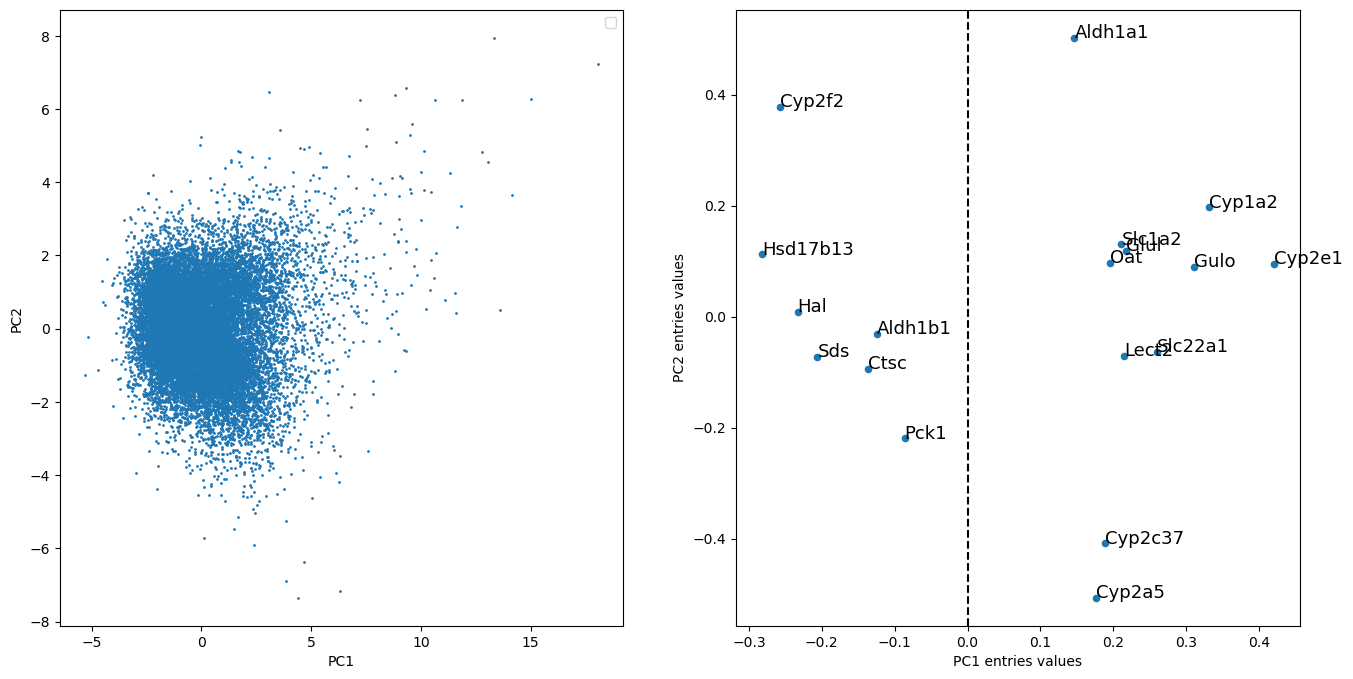

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(PC[:, 0], PC[:, 1],  s=1)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]

plt.subplot(122)
plt.scatter(x, y, 20)
ix = np.abs(x) > np.percentile(np.abs(x), 0)
iy = np.abs(y) > np.percentile(np.abs(y), 0)
ii = np.logical_or(ix, iy)
# print(np.sum(ii))
for i, txt in enumerate(data.var.index[ii]):
    plt.annotate(txt, (x[ii][i], y[ii][i]), fontsize=13)

#plot a vertical line for x = 0
plt.axvline(x=0, color='k', linestyle='--')

plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")


We can observe that PC1 perfectly separates protal to central genes, we therefore leverage the projection of data on such first principal component to initialize the bayesian model latent variables

In [8]:
# component that captures zonation, it needs to be checked
pc = 0
x_unif = PC[:, pc]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())

Here we also fit the the gene coefficients $a_g$ and $b_g$ with a Generalized Linear Model with Negative Bionomial noise: 
$$\forall c \forall g \\
\mu_{c,g} = exp(a_g * x_c + b_g)
$$
where $\mu_{c,g}$ is the mean of the negative binomial distrbution that generates the data entry $E_{c,g}$  
In this step the positions are kept fixed and the coefficients $a$ and $b$ are found for every gene

In [9]:
coef_pau = md.fit_coeff(data, x_unif, cfg.genes)

# SVI

In [10]:
a0_pau = coef_pau[:, 0]
a1_pau = coef_pau[:, 1]

In [11]:
DATA = data[:, :].layers["n_cg"]

NC = DATA.shape[0]
NG = DATA.shape[1]


# INTIALISE BOTH!
X = x_unif.reshape(NC, 1)
A1 = a1_pau.reshape(1, NG)
A0 = a0_pau.reshape(NG)

DISP = 0.3


# resizing the data

# mask for first 2 samples ....
num_samples = 11
keep = sample_id < num_samples
n_data = keep.sum()
DATA = DATA[0:n_data, :]

NC2 = DATA.shape[0]

X = X[0:n_data]
log_c = np.log(np.array(data.obs["n_c"])[0:n_data]).reshape(n_data, 1)

design_matrix = md.make_design_matrix_numpy(sample_id)
design_matrix = design_matrix[0:n_data, 0:num_samples]

NS2 = design_matrix.shape[1]

In [12]:
DATA.shape
design_matrix.shape

(20080, 11)

In [13]:
# A0 = a0_pau.reshape(1, NG)
A0 = [A0 for i in range(NS2)]
A0 = np.stack(A0)
A0.shape

(11, 18)

In [14]:
mp = dict(
    a0_loc=A0,
    a1_loc=A1,
    x=X,
    log_n_UMI=log_c,
    disp=0.3,
    dm=design_matrix,
)
MyTuple = namedtuple("param", mp)
MP = MyTuple(**mp)

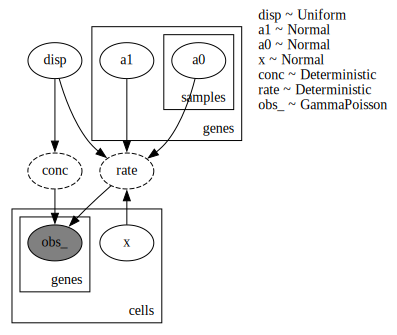

In [18]:
rng_key = random.PRNGKey(0)
exec_trace = trace(seed(md.model, rng_key)).get_trace(MP, DATA)
# pp.pprint(exec_trace)

numpyro.render_model(md.model, model_args=(MP, DATA), render_distributions=True)

# Model

In [22]:
# A0

In [23]:
init_params = {"a1": A1, "a0": A0, "x": X, "disp": 0.3}

In [25]:
nuts_kernel = NUTS(md.model)

# initalise samples
mcmc = MCMC(
    sampler=nuts_kernel,
    num_warmup=500,
    num_samples=1500,
    num_chains=1,
    progress_bar=True,
)
# init params flag does not work!

mcmc.run(rng_key, MP, y=DATA, init_params=init_params)


warmup:   0%|          | 8/2000 [01:07<6:13:28, 11.25s/it, 6 steps of size 5.83e-04. acc. prob=0.41]   

# Analysis of MCMC sampling

In [ ]:
samples = mcmc.get_samples()
means = dict()
errors = dict()
for key in samples.keys():
    means[key] = samples[key].mean(axis=0).squeeze()
    errors[key] = samples[key].std(axis=0).squeeze()

a0_pyro = means["a0"].flatten()
a1_pyro = means["a1"].flatten()
x_pyro = means["x"].flatten()
disp = means["disp"].flatten()

x_pyro = x_pyro.clone()

# x_mean=samples['x'][1000:,:].mean(axis=0).shape

Text(0, 0.5, 'x MCMC')

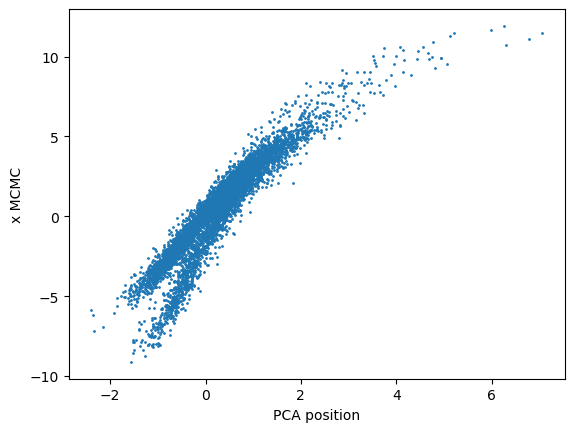

In [ ]:
plt.scatter(x_unif[0:n_data], x_pyro, s=1)
# axis labels
plt.xlabel("PCA position")
plt.ylabel("x MCMC")

In [ ]:
samples["a0"].shape

(1500, 2, 18)

['Oat', 'Cyp2e1', 'Lect2', 'Cyp2c37', 'Gulo', 'Cyp2a5', 'Glul', 'Aldh1a1', 'Cyp1a2', 'Slc22a1', 'Slc1a2', 'Pck1', 'Aldh1b1', 'Ctsc', 'Sds', 'Hal', 'Hsd17b13', 'Cyp2f2']


/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

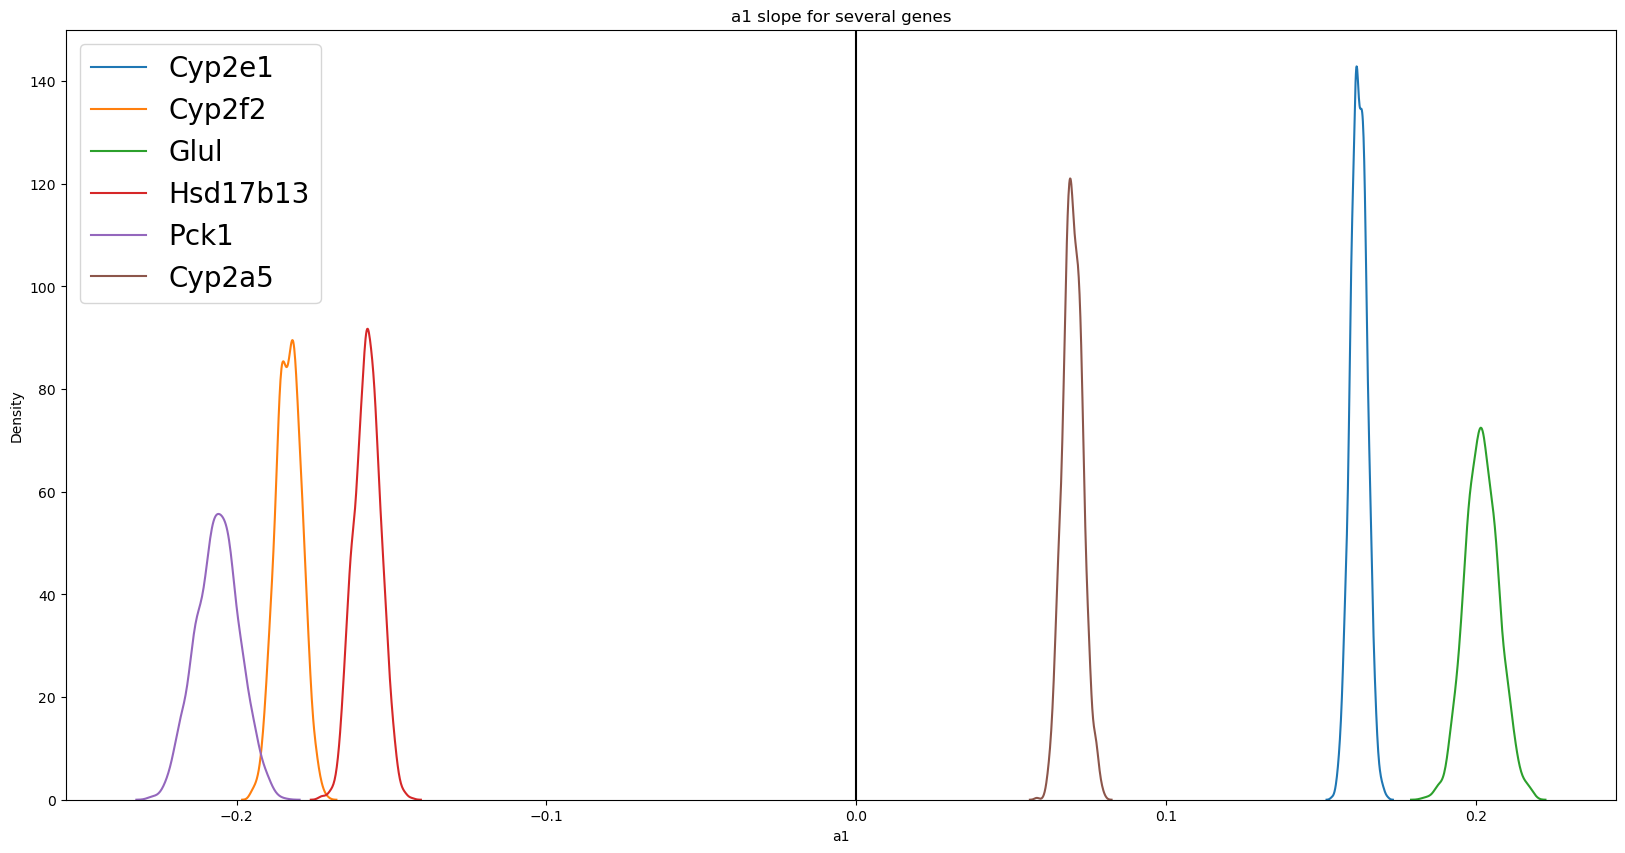

In [ ]:
print(genes)

# plot distributions of a1 for gene Cyp2e1 (index  = 1), use a smoothed histogram with displot
import seaborn as sns

gene_index(data_pyro, "Cyp2e1")
plt.figure(figsize=(20, 10))

sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, "Cyp2e1")], label="Cyp2e1")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, "Cyp2f2")], label="Cyp2f2")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, "Glul")], label="Glul")
sns.kdeplot(
    samples["a1"].squeeze()[:, gene_index(data_pyro, "Hsd17b13")], label="Hsd17b13"
)
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, "Sds")], label="Pck1")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, "Cyp2a5")], label="Cyp2a5")

# for g in genes:
#     sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, g)],  label=g)


# vertical line at x = 0
plt.axvline(0, color="black")
plt.xlabel("a1")

# add gene name on the plot itself rather than in the legend
# plt.text(0.1, 0.1, "Cyp2e1", transform=plt.gca().transAxes)

plt.title("a1 slope for several genes")
# bigger legend
plt.legend(fontsize=20)

# plt.figure(figsize=(20, 10))
# for i, g in enumerate(genes):
#     plt.subplot(5, 10, i + 1)
#     plt.hist(samples["a1"][:, i], bins=100, density=True)
#     plt.title(g)
#     plt.axvline(a1_pau[i], color="red")
#     plt.axvline(a1_pyro[i], color="green")
# samples['a1'].shape

In [ ]:
samples["a0"].shape

(1500, 2, 18)

/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

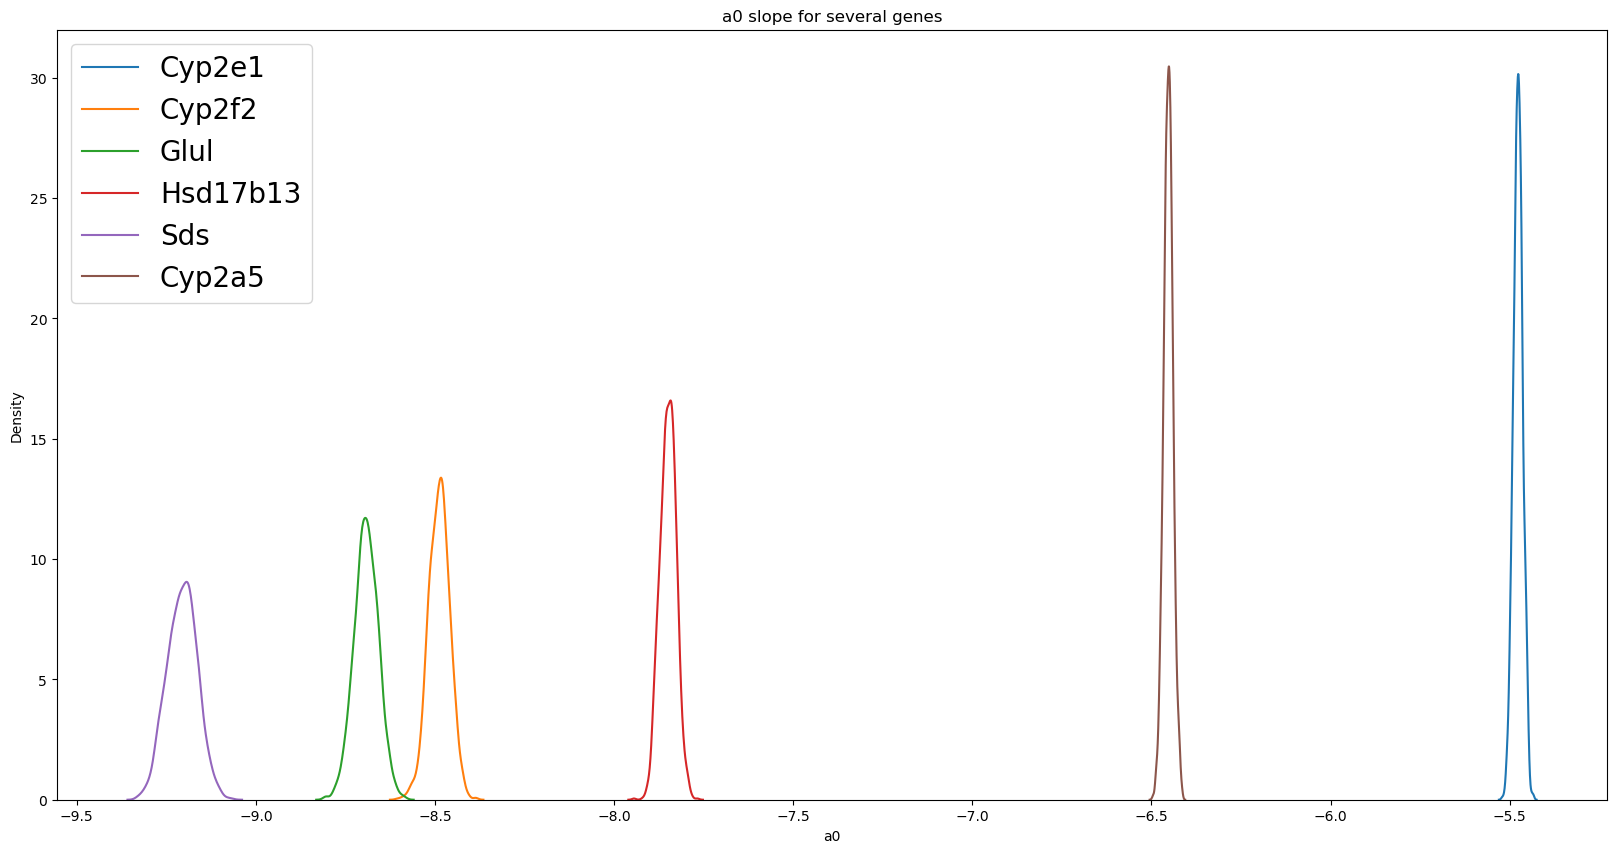

In [ ]:
plt.figure(figsize=(20, 10))

sns.kdeplot(samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Cyp2e1")], label="Cyp2e1")
sns.kdeplot(samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Cyp2f2")], label="Cyp2f2")
sns.kdeplot(samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Glul")], label="Glul")
sns.kdeplot(
    samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Hsd17b13")], label="Hsd17b13"
)
sns.kdeplot(samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Sds")], label="Sds")
sns.kdeplot(samples["a0"].squeeze()[:,0, gene_index(data_pyro, "Cyp2a5")], label="Cyp2a5")
# vertical line at x = 0

plt.xlabel("a0")

# add gene name on the plot itself rather than in the legend
# plt.text(0.1, 0.1, "Cyp2e1", transform=plt.gca().transAxes)

plt.title("a0 slope for several genes")
# bigger legend
plt.legend(fontsize=20)

In [ ]:
samples["x"].squeeze().shape

(1500, 5680)

/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

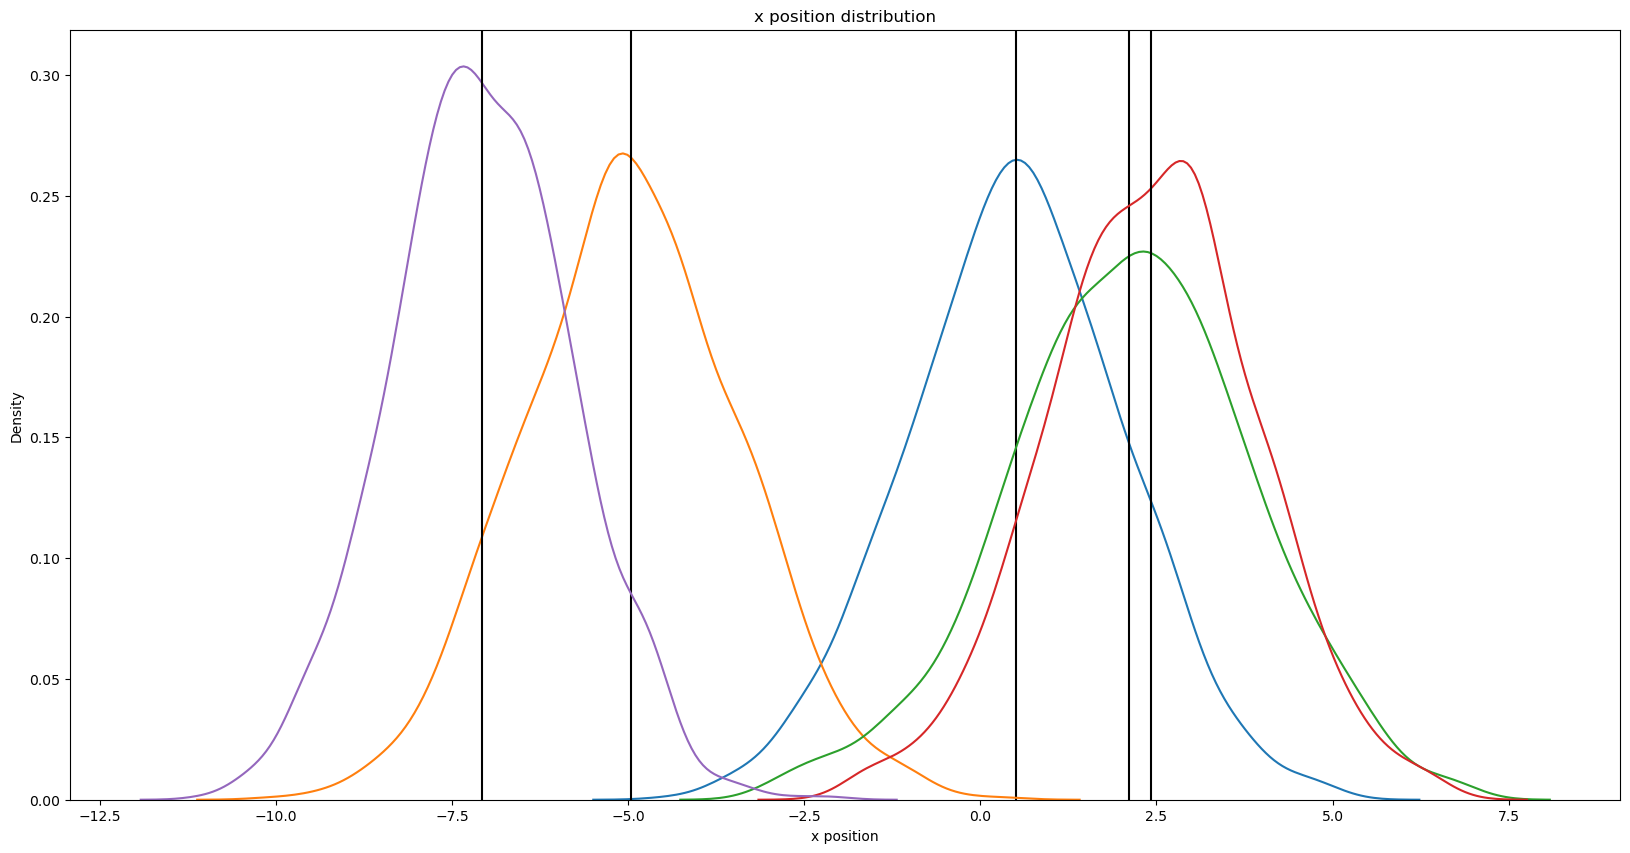

In [ ]:
# now the same but with position x, I will take 10 random positions
# and than plot the distributions in the same style as above

plt.figure(figsize=(20, 10))
plt.title("x position distribution")
plt.xlabel("x position")
for i in range(5):
    # for i in [2,3]:

    sns.kdeplot(samples["x"].squeeze()[:, i], label="point")
    plt.axvline(x_pyro[i], color="black")

In [ ]:
x_pyro[0:5]

Array([ 0.50478035, -4.956543  ,  2.1106887 ,  2.4265947 , -7.0671444 ],      dtype=float32)

In [ ]:
# compute p value for population of samples['x'].squeeze()[:,0] and samples['x'].squeeze()[:,0]
# using the t-test
from scipy.stats import ttest_ind

print(x_pyro[2], x_pyro[3])
print(samples["x"].squeeze()[:, 2].mean())
# print the std
print(errors["x"][2], errors["x"][3])

ttest_ind(samples["x"].squeeze()[:, 2], samples["x"].squeeze()[:, 3])

2.1106887 2.4265947
2.1106887
1.7441918 1.486913


TtestResult(statistic=-5.336427979045812, pvalue=1.0185847851048373e-07, df=2998.0)

In [ ]:
ttest_ind([1, 2, 3], [1, 2, 3])

ttest_ind([1, 2, 3], [100, 101, 102])

TtestResult(statistic=-121.24974226776732, pvalue=2.7747958781457153e-08, df=4.0)

In [ ]:
# # evaluates the likelihood
# def like_values(x, a0, a1, disp, log_UMI, DATA):
#     y = x[:, None] * a1[None, :] + log_UMI[:, None] + a0[None, :]
#     mu_cg_pyro = jnp.exp(y)
#     like_pyro = dist.GammaPoisson(concentration=1 / disp, rate=1 / (disp * mu_cg_pyro))
#     ll_cg_pyro = like_pyro.log_prob(DATA)
#     print(ll_cg_pyro.sum())
#     print(ll_cg_pyro.mean())
#     return ll_cg_pyro.sum(), ll_cg_pyro.mean()


# print("initial loss")
# like_0_sum, like_0_mean = like_values(X, A0, A1, disp, MP.log_n_UMI, DATA)
# print("final loss")
# like_final_sum, like_final_mean = like_values(
#     x_pyro, a0_pyro, a1_pyro, disp, MP.log_n_UMI, DATA
# )

0.11285048 0.0030649344


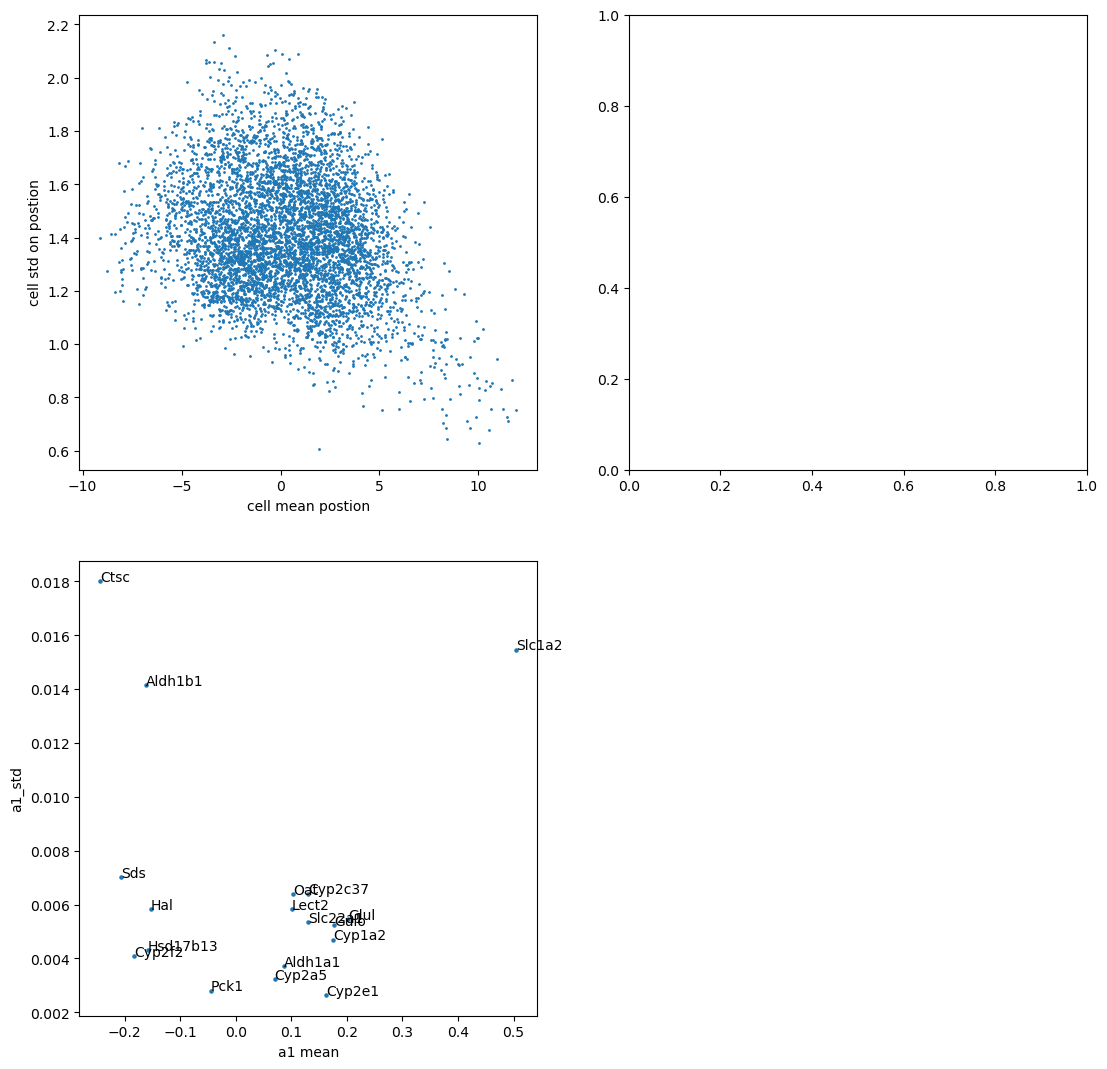

In [ ]:
plt.figure(figsize=(13, 13))

plt.subplot(221)
plt.scatter(means["x"], errors["x"], s=1)
plt.xlabel("cell mean postion")
plt.ylabel("cell std on postion")

plt.subplot(222)
# plt.scatter(means["a0"], errors["a0"], s=5)
# for i, txt in enumerate(data_pyro.var.index):
#     plt.annotate(txt, (means["a0"][i], errors["a0"][i]))
# plt.xlabel("a0 mean")
# plt.ylabel("a0_std")

plt.subplot(223)
plt.scatter(means["a1"], errors["a1"], s=5)
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(txt, (means["a1"][i], errors["a1"][i]))
plt.xlabel("a1 mean")
plt.ylabel("a1_std")

print(means["disp"], errors["disp"])

ValueError: x and y must be the same size

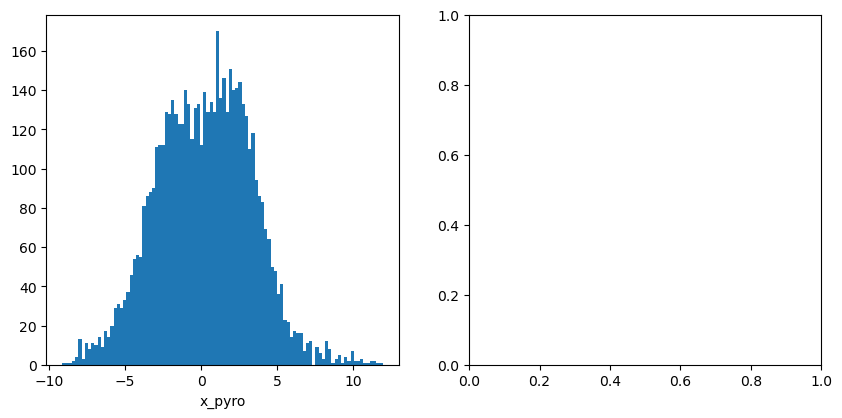

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.hist(x_pyro, bins=100)
plt.xlabel("x_pyro")

plt.subplot(222)
plt.scatter(x_unif, x_pyro, s=2, c=sample_id)
plt.xlabel("x_PCA")
plt.ylabel("x_pyro")
plt.axline((0, 0), slope=1, c="red")

plt.subplot(223)
plt.scatter(a1_pau, a1_pyro, s=2)
plt.xlabel("a1_pau")
plt.ylabel("a1_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a1_pau[i], a1_pyro[i]))

plt.subplot(224)
plt.scatter(a0_pau, a0_pyro, s=2)
plt.xlabel("a0_pau")
plt.ylabel("a0_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a0_pau[i], a0_pyro[i]))


print(disp)

In [ ]:
# df_a0 = pd.DataFrame(a0_pyro,index=sample_list ,columns=data_pyro.var.index)
# df_a1 = pd.Series(a1_pyro, index=data_pyro.var.index)
# df_x  = pd.Series(x_pyro, index=data_pyro.obs.index)

# # Write the DataFrame to a .txt file
# df_a0.to_csv("coeff_values/fit_a_hild_genes_a0.txt", sep="\t")
# df_a1.to_csv("coeff_values/fit_a_hild_genes_a1.txt", sep="\t")
# df_x.to_csv("coeff_values/fit_a_hild_genes_x.txt",   sep="\t")

# plots

## shifts

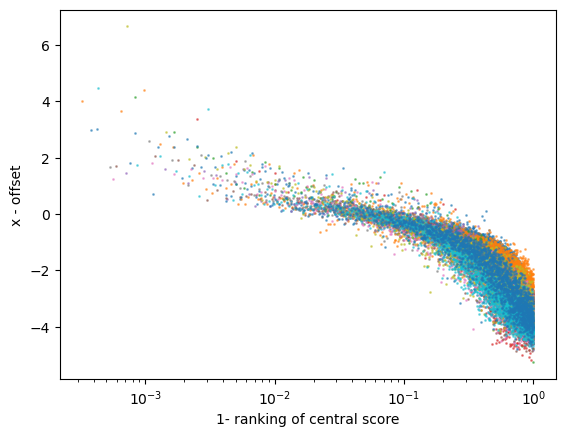

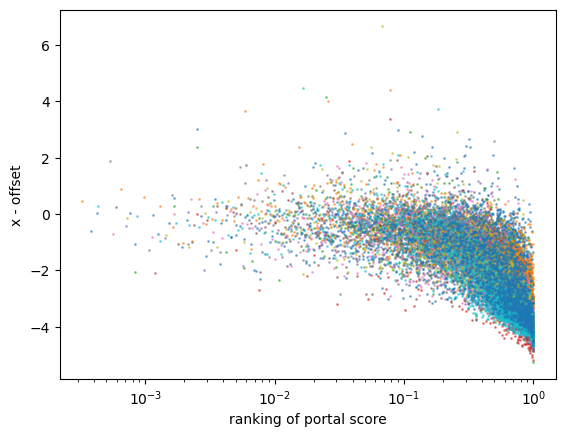

In [ ]:
xs = []
# central2=['Glul', 'Slc1a2']
for s in np.unique(sample_id):
    # print(s)
    idx = sample_id == s
    central_score = data[idx, central].layers["f_cg"].sum(1)
    x = x_pyro[idx]
    rc = central_score.argsort().argsort() / idx.sum()
    offset = x[np.logical_and(rc > 0.9, rc < 0.99)].median()
    col = np.logical_and(rc > 0.9, rc < 0.99)
    xs.append(offset)
    plt.scatter(1 - rc, x - offset, s=1, alpha=0.5)
    plt.xlabel("1- ranking of central score")
    plt.ylabel("x - offset")
    plt.xscale("log")
plt.show()
xs

for s in np.unique(sample_id):
    idx = sample_id == s
    portal_score = data[idx, portal].layers["f_cg"].sum(1)
    x = x_pyro[idx]
    rp = portal_score.argsort().argsort() / idx.sum()
    # offset=x[np.logical_and(r>0.9, r<0.99)].median()
    # xs.append(offset)
    plt.scatter(rp, x - xs[s], s=1, alpha=0.5)
    plt.xscale("log")
    plt.xlabel("ranking of portal score")
    plt.ylabel("x - offset")

In [ ]:
# # plt.figure(figsize=(10,5))
# for s in np.unique(sample_id):
#     x=x_pyro[sample_id==s]
#     x=x-xs[s]+2
#     plt.hist(x, bins=100, alpha=0.5, label=s)
#     plt.xlim((-5,5))
#     plt.xlabel('x_pyro')
#     plt.title(' '.join(sample_annot[s,3:]))
#     plt.show()
# plt.legend()

In [ ]:
# change=12
# mask_mt=data.obs['percent.mt']<change
# mask_mt2=data.obs['percent.mt']>change

# cor1=np.corrcoef(x_pyro[mask_mt],data[mask_mt,:].obs['percent.mt'])[0,1]
# cor2=np.corrcoef(x_pyro[mask_mt2],data[mask_mt2].obs['percent.mt'])[0,1]

# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.scatter(x_pyro[mask_mt],data[mask_mt,:].obs['percent.mt'],s=1,label=cor1)
# plt.xlabel('x_pyro')
# plt.ylabel('perc_mito')
# plt.title('less than {}% mito'.format(change) )
# plt.legend()


# plt.subplot(122)
# plt.scatter(x_pyro[mask_mt2],data[mask_mt2,:].obs['percent.mt'],s=1, label=cor2)
# plt.xlabel('x_pyro')
# plt.ylabel('perc_mito')
# plt.title('more than {}% mito'.format(change) )
# plt.legend()